In this file we are using Transfer Learning concept to classify Indian dance form. Transfer Learning used when we have very less training data. In image processing, training with less data does not give good results. So we are using Transfer Learning to get weights. This notebook use *tensorflow* *VGG16* and the purpose of this notbook to show how to use Transfer Learning for image classification 

In [5]:
# import required libraries 
import os
import pandas as pd
import numpy as np
!pip install opencv-python

import cv2
import matplotlib.pyplot as plt
!pip install tensorflow

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import Flatten,Dense,Dropout,BatchNormalization
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization

from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split

from tensorflow.keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop

from sklearn.preprocessing import LabelEncoder

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/376.0 MB ? eta -:--:--
   ---------------------------------------- 1.0/376.0 MB 7.2 MB/s eta 0:00:52
   ---------------------------------------- 2.6/376.0 MB 6.9 MB/s eta 0:00:55
   ---------------------------------------- 3.9/376.0 MB 6.9 MB/s eta 0:00:54
    --------------------------------------- 5.5/376.0 MB 7.0 MB/s eta 0:00:53
    --------------------------------------- 6.3/376.0 MB 6.5 MB/s eta 0:00:57
    --------------------------------------- 7.9/376.0 MB 6.6 MB/s eta 0:00:56
   - -------------------------------------- 9.4/376.0 MB 6.7 MB/s eta 0:00:55
   - -------------------------------------- 10.7/376.0 MB 6.6 MB/s eta 0:00:55
   - -------------------------------------- 12.3/376.0 MB 6.7 MB/s eta 0:00:55
   - -------------------------------------- 13.6/376.0 MB 6.7 MB/s et

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [19]:
# Load train and test csv file for image class
train = pd.read_csv('C:/Users/Keerthana S/Downloads/Identify-the-dance-form-master/Identify-the-dance-form-master/train.csv')
test = pd.read_csv('C:/Users/Keerthana S/Downloads/Identify-the-dance-form-master/Identify-the-dance-form-master/test.csv')

print(train.head())
print(test.head())
print(train['target'].value_counts())

     Image         target
0   96.jpg       manipuri
1  163.jpg  bharatanatyam
2  450.jpg         odissi
3  219.jpg      kathakali
4  455.jpg         odissi
     Image
0  508.jpg
1  246.jpg
2  473.jpg
3  485.jpg
4  128.jpg
target
mohiniyattam     50
odissi           49
bharatanatyam    47
kathakali        47
kuchipudi        46
sattriya         45
kathak           44
manipuri         36
Name: count, dtype: int64


In [16]:
train.head()

,Image,target
0,96.jpg,manipuri
1,163.jpg,bharatanatyam
2,450.jpg,odissi
3,219.jpg,kathakali
4,455.jpg,odissi


Basic Histrogram plot to check number of training data for each dance form. 

<Axes: xlabel='target'>

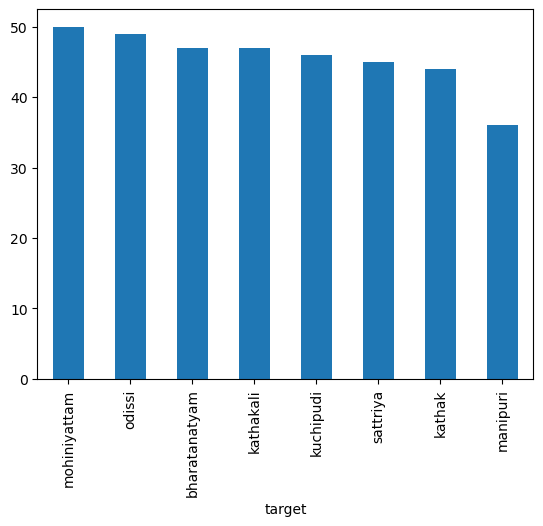

In [19]:
#Histogram chart for target
train['target'].value_counts().plot(kind='bar')

In [9]:
base='C:/Users/Keerthana S/Downloads/Identify-the-dance-form-master/Identify-the-dance-form-master'
train_dir = os.path.join(str(base)+ '/train/')
test_dir = os.path.join(str(base)+'/test/')

train_fnames = os.listdir(train_dir)
test_fnames = os.listdir(test_dir)

print(train_fnames[:9])
print(test_fnames[:9])

['1.jpg', '10.jpg', '100.jpg', '101.jpg', '102.jpg', '103.jpg', '104.jpg', '105.jpg', '106.jpg']
['108.jpg', '11.jpg', '110.jpg', '112.jpg', '114.jpg', '119.jpg', '125.jpg', '128.jpg', '129.jpg']


In [11]:
# Images migh be in different size. In this section I assigning all image at same size of 224*224
img_width = 224
img_height = 224

Below two section used for data preprocessing. We are reading image data using OpenCV and converting into numeric formate.

In [13]:
# this function reads image from the disk,train file for image and class maping and returning output in numpy array formate
# for input and target data
def train_data_preparation(list_of_images, train, train_dir):
    """
    Returns two arrays: 
        x is an array of resized images
        y is an array of labels
    """
    x = [] # images as arrays
    y = [] # labels
    for image in list_of_images:
        #x.append((cv2.resize(cv2.imread(train_dir+image), (img_width,img_height), interpolation=cv2.INTER_CUBIC)).astype('float32'))
        x.append(cv2.resize(cv2.imread(train_dir+image), (img_width,img_height), interpolation=cv2.INTER_CUBIC))
        if image in list(train['Image']):
            y.append(train.loc[train['Image'] == image, 'target'].values[0])
    
            
    return x, y

In [21]:
def test_data_prepare(list_of_images, test_dir):
    """
    Returns two arrays: 
        x is an array of resized images
        y is an array of labels
    """
    x = [] # images as arrays
    
    for image in list_of_images:
        x.append(cv2.resize(cv2.imread(test_dir+image), (img_width,img_height), interpolation=cv2.INTER_CUBIC)) 
            
    return x

In [23]:
training_data, training_labels = train_data_preparation(train_fnames, train, train_dir)

In [42]:
training_labels[:10]

['kathakali',
 'mohiniyattam',
 'manipuri',
 'kuchipudi',
 'bharatanatyam',
 'mohiniyattam',
 'bharatanatyam',
 'bharatanatyam',
 'mohiniyattam',
 'kathakali']

In [25]:
training_data[1]

array([[[30, 34, 35],
        [30, 34, 35],
        [30, 34, 35],
        ...,
        [26, 31, 30],
        [26, 31, 30],
        [26, 31, 30]],

       [[30, 34, 35],
        [30, 34, 35],
        [30, 34, 35],
        ...,
        [26, 31, 30],
        [26, 31, 30],
        [26, 31, 30]],

       [[30, 34, 35],
        [30, 34, 35],
        [30, 34, 35],
        ...,
        [26, 31, 30],
        [26, 31, 30],
        [26, 31, 30]],

       ...,

       [[56, 91, 47],
        [56, 91, 47],
        [56, 91, 47],
        ...,
        [31, 40, 41],
        [32, 40, 39],
        [32, 40, 39]],

       [[56, 91, 47],
        [56, 91, 47],
        [56, 91, 47],
        ...,
        [31, 39, 41],
        [31, 39, 38],
        [31, 39, 38]],

       [[55, 90, 46],
        [55, 90, 46],
        [55, 90, 46],
        ...,
        [30, 39, 41],
        [30, 38, 37],
        [30, 38, 37]]], dtype=uint8)

In [27]:

def show_batch(image_batch, label_batch):
    plt.figure(figsize=(12,12))
    for n in range(25):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        plt.title(label_batch[n].title())
        plt.axis('off')

Just showing loaded data for first 25 image

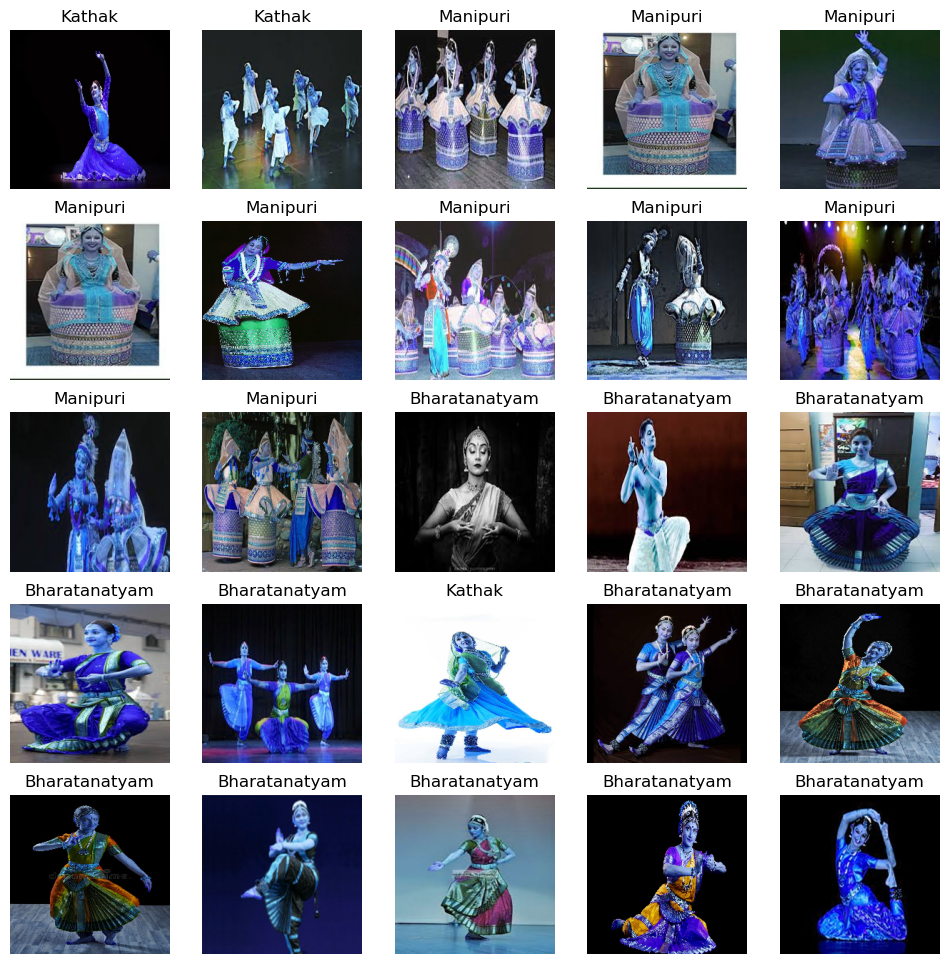

In [29]:
show_batch(training_data, training_labels)

In [31]:
testing_data = test_data_prepare(test_fnames, test_dir)

Using label incoder converting target class to numeric format

In [33]:
le =LabelEncoder()
training_labels=le.fit_transform(training_labels)

In this section I am using ougumentation techniques to generate more data for given input

In [35]:
training_labels[:10]

array([1, 1, 4, 4, 4, 4, 4, 4, 4, 4], dtype=int64)

In [37]:
X_train, X_val, y_train, y_val = train_test_split(training_data, training_labels, test_size=0.33, random_state=42)

In [39]:
# subsetting validation data
validation_data = training_data[300:]
validation_label =training_labels[300:]
training_data = training_data[:300]
training_labels = training_labels[:300]

In [42]:
train_datagenerator = ImageDataGenerator(
        rescale=1. / 255,
        featurewise_center=False,  
        samplewise_center=False,  
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False,  
        rotation_range=40,  
        zoom_range = 0.20,  
        width_shift_range=0.10,  
        height_shift_range=0.10,  
        horizontal_flip=True,  
        vertical_flip=False) 


test_datagenerator=ImageDataGenerator(
        rescale=1. / 255
)

train_datagenerator.fit(X_train)
test_datagenerator.fit(X_val)
test_datagenerator.fit(testing_data)
X_train=np.array(X_train)
testing_data=np.array(testing_data)
X_val=np.array(X_val)

In [44]:
validation_data[0]


array([[[  4,   3,   7],
        [  4,   3,   7],
        [  4,   3,   7],
        ...,
        [  4,   3,   7],
        [  4,   3,   7],
        [  3,   2,   6]],

       [[  4,   3,   7],
        [  4,   3,   7],
        [  4,   3,   7],
        ...,
        [  4,   3,   7],
        [  4,   3,   7],
        [  3,   2,   6]],

       [[  4,   3,   7],
        [  4,   3,   7],
        [  4,   3,   7],
        ...,
        [  4,   3,   7],
        [  4,   3,   7],
        [  3,   2,   6]],

       ...,

       [[100,  30,  61],
        [111,  41,  72],
        [106,  36,  67],
        ...,
        [155,  66,  86],
        [152,  63,  83],
        [154,  66,  82]],

       [[111,  46,  76],
        [103,  38,  69],
        [ 96,  30,  61],
        ...,
        [155,  64,  84],
        [151,  61,  81],
        [152,  63,  79]],

       [[106,  39,  68],
        [105,  39,  67],
        [ 97,  30,  59],
        ...,
        [137,  45,  61],
        [137,  45,  61],
        [139,  47,  62]]

In [46]:
training_labels[:10]

array([1, 1, 4, 4, 4, 4, 4, 4, 4, 4], dtype=int64)

In [48]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

(243, 224, 224, 3)
(243,)
(121, 224, 224, 3)
(121,)


In below code we are loading *VGG16* weights for image classifier using transfer learning

In [50]:
# traing using transfer learning

vggmodel =VGG16(weights='imagenet', include_top=False, input_shape = (224, 224, 3),pooling='max')

 # Print the model summary
vggmodel.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 32s 1us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling2d            │ (None, 512)            │             0 │
│ (GlobalMaxPooling2D)            │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

Using already trained model for our task and bulding 2 fully connected layer with *softmax* activation function

In [54]:
vggmodel.trainable = False
model = Sequential([
  vggmodel, 
  Dense(1024, activation='relu'),
  Dropout(0.25),
  Dense(256, activation='relu'),
  Dropout(0.25),
  Dense(8, activation='softmax'),
])

In [56]:

reduce_learning_rate = ReduceLROnPlateau(monitor='loss',
                                         factor=0.1,
                                         patience=2,
                                         cooldown=2,
                                         min_lr=0.00001,
                                         verbose=1)

callbacks = [reduce_learning_rate]

In the below code we are compiling and traing our image data

In [66]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagenerator = ImageDataGenerator(rescale=1./255)
model.compile( optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
history =model.fit(
    datagenerator.flow(X_train, to_categorical(y_train,8), batch_size=16),
    validation_data=datagenerator.flow(X_val, to_categorical(y_val,8), batch_size=16),
    verbose=2,
    epochs=30,
    callbacks=callbacks
)

Epoch 1/30


C:\Users\Keerthana S\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


16/16 - 68s - 4s/step - accuracy: 0.1193 - loss: 2.7234 - val_accuracy: 0.2479 - val_loss: 2.1408 - learning_rate: 0.0010
Epoch 2/30
16/16 - 68s - 4s/step - accuracy: 0.2840 - loss: 1.9871 - val_accuracy: 0.3967 - val_loss: 1.7081 - learning_rate: 0.0010
Epoch 3/30
16/16 - 68s - 4s/step - accuracy: 0.3539 - loss: 1.7146 - val_accuracy: 0.2975 - val_loss: 1.6298 - learning_rate: 0.0010
Epoch 4/30
16/16 - 68s - 4s/step - accuracy: 0.4403 - loss: 1.5407 - val_accuracy: 0.4298 - val_loss: 1.5214 - learning_rate: 0.0010
Epoch 5/30
16/16 - 68s - 4s/step - accuracy: 0.5267 - loss: 1.3367 - val_accuracy: 0.4959 - val_loss: 1.3632 - learning_rate: 0.0010
Epoch 6/30
16/16 - 68s - 4s/step - accuracy: 0.6955 - loss: 1.0116 - val_accuracy: 0.5455 - val_loss: 1.1811 - learning_rate: 0.0010
Epoch 7/30
16/16 - 116s - 7s/step - accuracy: 0.7407 - loss: 0.8038 - val_accuracy: 0.5289 - val_loss: 1.2209 - learning_rate: 0.0010
Epoch 8/30
16/16 - 69s - 4s/step - accuracy: 0.6502 - loss: 0.9989 - val_accura

Text(0.5, 1.0, 'Training and validation loss')

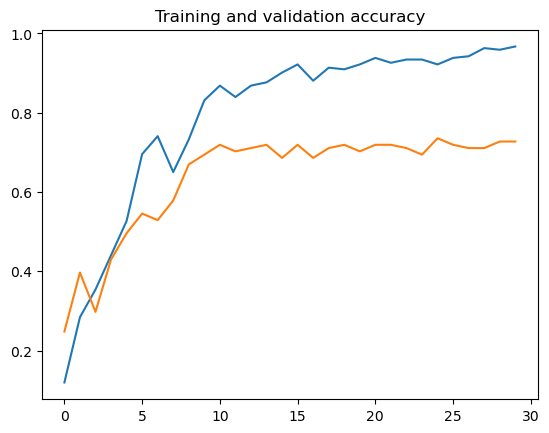

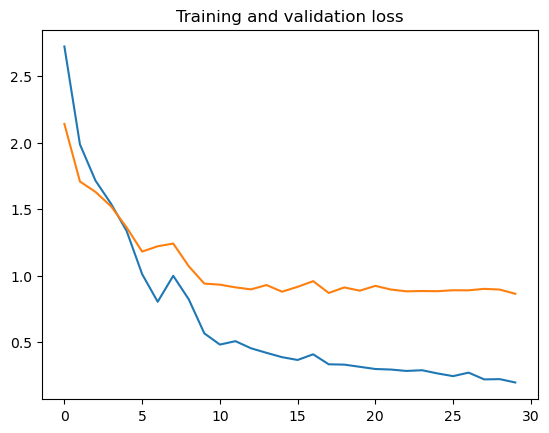

In [68]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

acc      = history.history[ 'accuracy' ]
val_acc  = history.history[ 'val_accuracy' ]
loss     = history.history[ 'loss' ]
val_loss = history.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot( epochs, acc )
plt.plot( epochs, val_acc )
plt.title('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  ( epochs,     loss )
plt.plot  ( epochs, val_loss )
plt.title ('Training and validation loss'   )

In [70]:
labels = model.predict(testing_data)
label = [np.argmax(i) for i in labels]


5/5 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step


In [71]:
target=le.inverse_transform(label)

In [74]:
target[:25]

array(['kathakali', 'kathakali', 'kathakali', 'bharatanatyam',
       'bharatanatyam', 'bharatanatyam', 'bharatanatyam', 'bharatanatyam',
       'bharatanatyam', 'kuchipudi', 'bharatanatyam', 'bharatanatyam',
       'bharatanatyam', 'kathakali', 'bharatanatyam', 'bharatanatyam',
       'bharatanatyam', 'bharatanatyam', 'bharatanatyam', 'bharatanatyam',
       'bharatanatyam', 'bharatanatyam', 'bharatanatyam', 'bharatanatyam',
       'kathakali'], dtype='<U13')

In [76]:
submission = pd.DataFrame({ 'Image': test.Image, 'target': target })
submission.to_csv('output2.csv', index=False)